# Experimental Variogram and Variogram Cloud classes

## Table of Contents:

1. Create Experimental Variogram with the `ExperimentalVariogram` class.
2. Create Experimental Variogram Point Cloud with the `VariogramCloud` class.


## Level: Basic

## Changelog

| Date       | Change description                                                                                                                                                     | Author                     |
|------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------|
| 2023-01-23 | The first release of the tutorial | @SimonMolinsky |


## Introduction

Geostatistical analysis starts with a dissimilarity estimation. We must know if process is spatially depended and at which distances points tend to be related to each other. Thus, we start from the experimental variogram estimation.

In this tutorial, we will take a closer look into the API, and we will learn what can be done with two basic experimental semivariogram estimation functionalities. One is `ExperimentalVariogram` class and another is `VariogramCloud` class. The first is a foundation of every other complex function, from semivariogram modeling up to Poisson Kriging. The latter is used for thorough analysis of relations between points and their dispersion.

To learn more about variogram and related concepts you can start from those tutorials:

- [Semivariogram Estimation](https://github.com/DataverseLabs/pyinterpolate/blob/main/tutorials/Semivariogram%20Estimation%20(Basic).ipynb)
- [Directional Semivariograms](https://github.com/DataverseLabs/pyinterpolate/blob/main/tutorials/Directional%20Semivariograms%20(Basic).ipynb)
- [Variogram Point Cloud](https://github.com/DataverseLabs/pyinterpolate/blob/main/tutorials/Variogram%20Point%20Cloud%20(Basic).ipynb)

We will use:

- **DEM data** stored in a file `samples/point_data/txt/pl_dem_epsg2180.txt`

## Import packages & read data

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pyinterpolate import read_txt, ExperimentalVariogram, VariogramCloud

In [5]:
dem = read_txt('samples/point_data/txt/pl_dem_epsg2180.txt')

# Take a sample
sample_size = int(0.05 * len(dem))
indices = np.random.choice(len(dem), sample_size, replace=False)
dem = dem[indices]

# Look into a first few lines of data
dem[:10, :]

array([[2.42207337e+05, 5.46881660e+05, 5.03191910e+01],
       [2.50856917e+05, 5.51689039e+05, 6.96442337e+01],
       [2.43882223e+05, 5.53252314e+05, 4.52078705e+01],
       [2.53679240e+05, 5.30855626e+05, 5.43067894e+01],
       [2.52375160e+05, 5.34773476e+05, 4.86135292e+01],
       [2.44833732e+05, 5.28542218e+05, 5.09161682e+01],
       [2.45380349e+05, 5.30266794e+05, 5.63001442e+01],
       [2.48391707e+05, 5.46418696e+05, 1.87953167e+01],
       [2.46936777e+05, 5.36967503e+05, 2.04066505e+01],
       [2.44688507e+05, 5.33463225e+05, 5.17071571e+01]])

## 1. Experimental Variogram class

Let's start from the `ExperimentalVariogram` class.

```python

class ExperimentalVariogram(
    input_array,
    step_size,
    max_range,
    weights=None,
    direction=None,
    tolerance=1.0,
    method='t',
    is_semivariance=True,
    is_covariance=True,
    is_variance=True)

```

The class has three required parameters and seven optional.

- `input_array` is a list of coordinates and values in a form `(x, y, value)`. Those are our observations.
- `step_size` parameter which describes distance between lags, and `max_range` which describes maximum range of analysis are hard to guess at a first run, so probably we will change those to find semivariogram features. Let's experiment with those parameters!

What we know at the beginning? That our coordinate reference system is metric, it is [EPSG:2180](https://epsg.io/2180). We don't know the limits of the region of interest, and we will check it:

In [6]:
# Get max distances for a region

minx = np.min(dem[:, 0])
maxx = np.max(dem[:, 0])

miny = np.min(dem[:, 1])
maxy = np.max(dem[:, 1])

x_max_distance = maxx - minx
y_max_distance = maxy - miny

print('Max lon distance:', x_max_distance)
print('Max lat distance:', y_max_distance)

Max lon distance: 18055.017384361156
Max lat distance: 25230.138770977966


We can assume, that the maximum distance `max_range` parameter shouldn't be larger than the maximum distance in a lower dimension (**18055** m). In reality, the `max_range` parameter is rather close to the halved value of this distance, and we can check it on a variogram.

But we don't know the `step_size` parameter... Let's assume that it is 100 meters and we will see if we've estimated it correctly.

In [10]:
max_range = 18055
step_size = 100

experimental_variogram = ExperimentalVariogram(
    input_array=dem,
    step_size=step_size,
    max_range=max_range
)

We will visually inspect semivariogram with the `.plot()` method of `ExperimentalVariogram` class: 

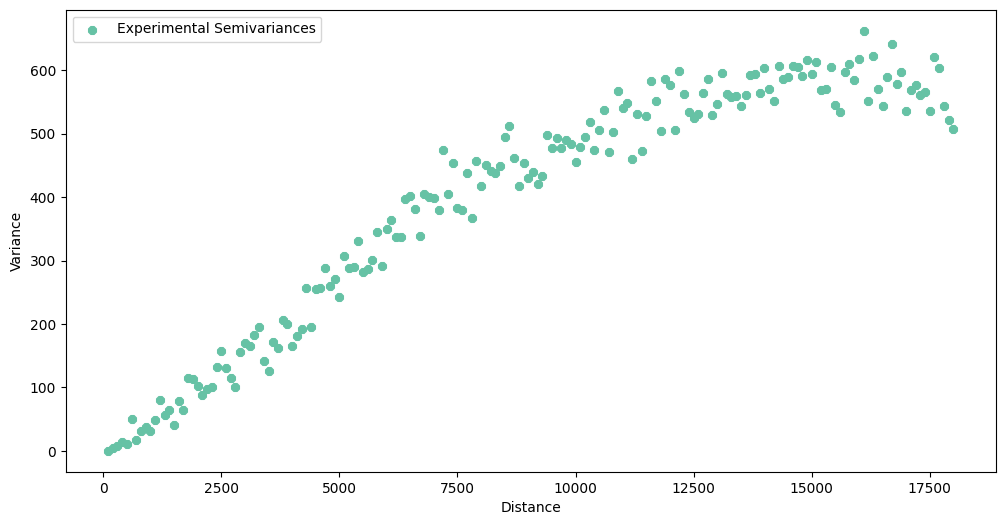

In [11]:
experimental_variogram.plot()

Variogram looks nice, but it introduces a lot of variance. We can see a trend, but points are oscillating around it. This piece of information tells us that `step_size` should be larger.

What with `max_range`? It is a tricky problem because variogram seems to be right up to the end of its range. But we should be aware, that this could be an effect of sampling points in the North-South axis (with a greater range).

We can check how many point pairs we have for each distance to make a better decision. The `ExperimentalVariogram` class stores information about points within its attribute `.experimental_semivariance_array`. It is `numpy` array with three columns: `[lag, semivariance, number of point pairs]` and we will use the last column to decide where to cut `max_range`.

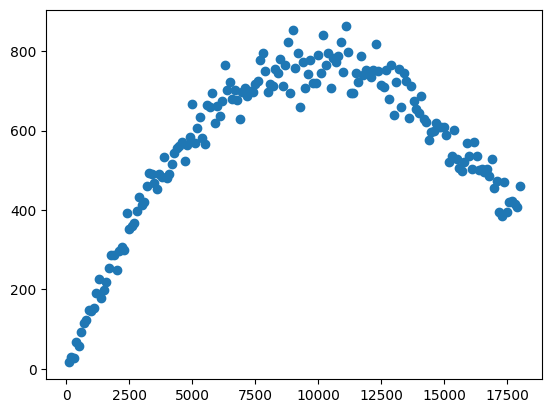

In [17]:
_ds = experimental_variogram.experimental_semivariance_array
plt.figure()
plt.scatter(x=_ds[:, 0], y=_ds[:, -1])
plt.show()

We clearly see that after 12 kilometers number of point pairs is rapidly falling, so we can set `max_range` to **12000**.

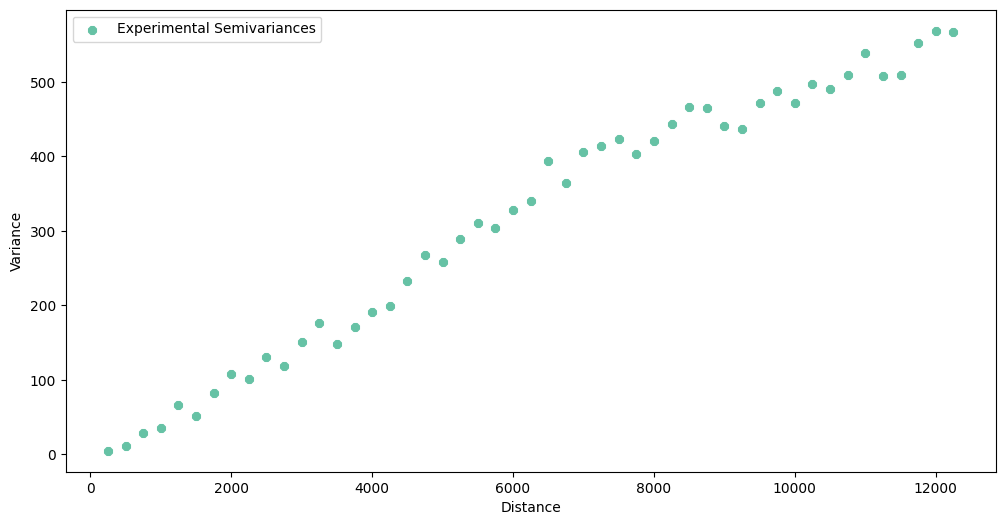

In [18]:
max_range = 12500
step_size = 250

experimental_variogram = ExperimentalVariogram(
    input_array=dem,
    step_size=step_size,
    max_range=max_range
)

experimental_variogram.plot()

This time variogram looks cleaner. However, it still has a little too much variance. Let's set `step_size` to 500 meters:

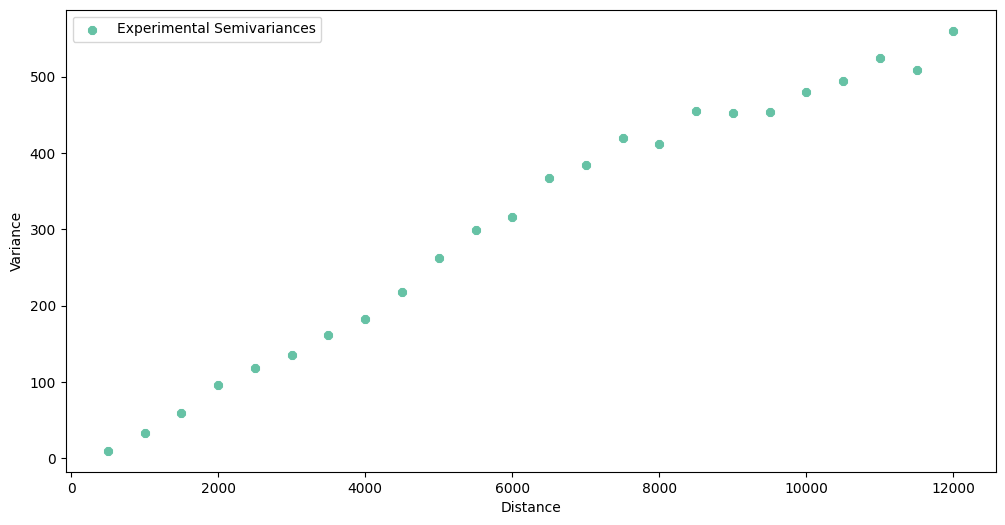

In [22]:
max_range = 12500
step_size = 500

experimental_variogram = ExperimentalVariogram(
    input_array=dem,
    step_size=step_size,
    max_range=max_range
)

experimental_variogram.plot()

We can use this variogram for further processing. With this in mind, we will make a use from two other parameters: `is_variance` and `is_covariance`. Both are set to `True` by default. What do they mean?

- if we want to know variance of a dataset (variance at lag 0) then we should set `is_variance` parameter to `True`. This value can be treated as the **sill** of variogram that we will use in semivariogram modeling and kriging.
- if we want to know covariance of a dataset then we should set `is_covariance` parameter to `True`. Covariance is a measure of spatial similarity, so it is opposite to semivariance. But we can use it in kriging systems instead of semivariance.

`ExperimentalVariogram` plotting function `.plot()` has additional parameters:

- `plot_semivariance` (boolean, set to `True` by default),
- `plot_covariance` (boolean, set to `False` by default),
- `plot_variance` (boolean, set to `False` by default).

We will set all those parameters to `True` and compare plot semivariance with covariance and variance:

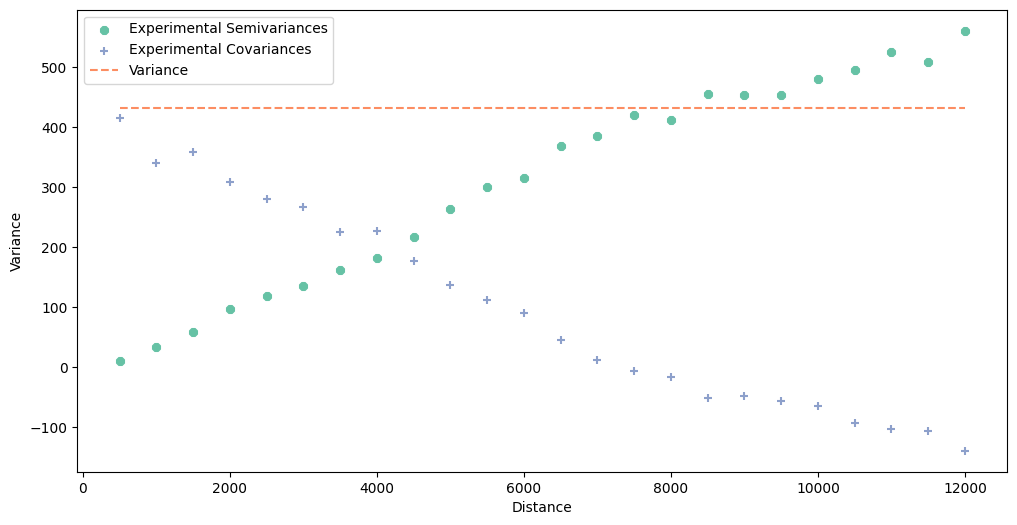

In [23]:
experimental_variogram.plot(
    plot_semivariance=True,
    plot_covariance=True,
    plot_variance=True)